In [19]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [3]:
from src.load_data import load_data

epoch_key = ('Jaq', 1, 4) # animal, day, epoch

data = load_data(epoch_key)

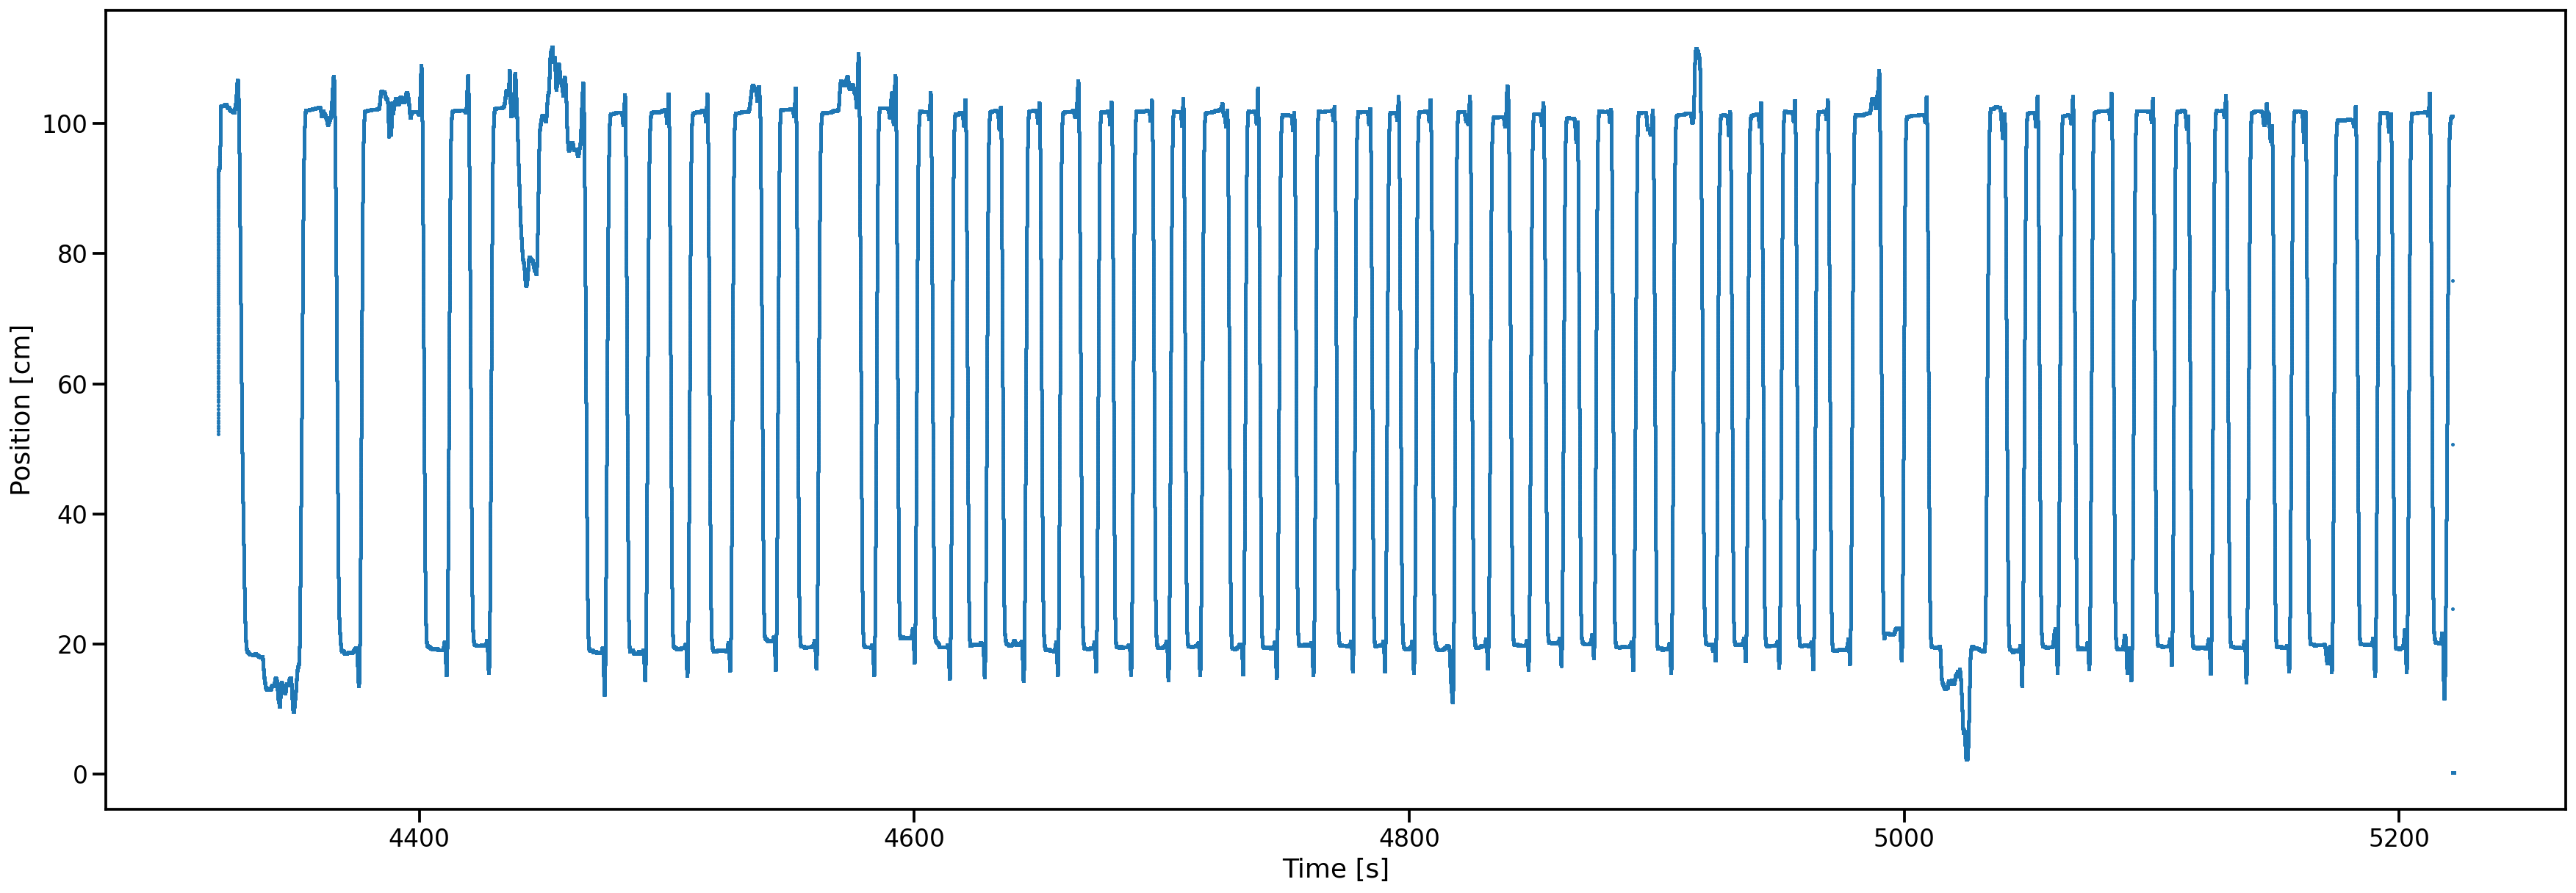

In [4]:
fig, ax = plt.subplots(figsize=(30, 10))

for edge_label, df in data['position_info'].groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

In [5]:
from src.load_data import make_track_graph
from src.parameters import ANIMALS

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

0

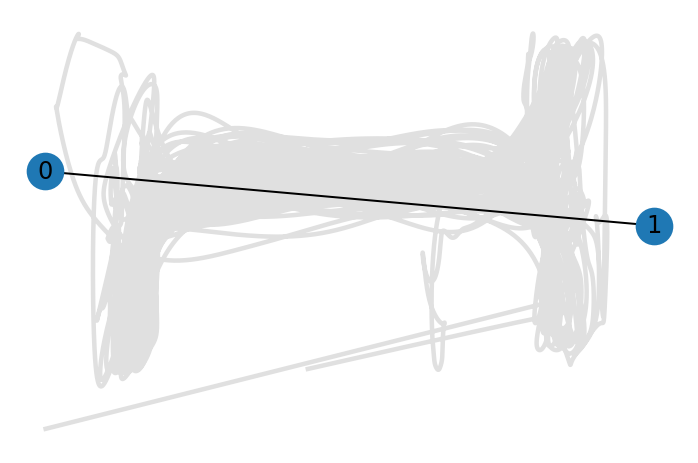

In [6]:
from loren_frank_data_processing.track_segment_classification import plot_track

plt.plot(data['position_info'].tail_x, data['position_info'].tail_y, color="lightgrey", alpha=0.7, zorder=-1)
plot_track(track_graph)
sns.despine(left=True, bottom=True)

center_well_id

In [7]:
is_running = np.abs(data["position_info"].tail_vel) > 4
EDGE_ORDER = [0]
EDGE_SPACING = 0

In [8]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import classifier_parameters, discrete_state_transition

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

cv = KFold()
cv_classifier_clusterless_results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f"Fold #{fold_ind}")
    cv_classifier = ClusterlessClassifier(**classifier_parameters)

    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        is_training=is_running.iloc[train],
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    cv_classifier.discrete_state_transition_ = discrete_state_transition
    logging.info('Predicting posterior...')
    cv_classifier_clusterless_results.append(
        cv_classifier.predict(
            data["multiunits"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )
logging.info("Done...")

17-Mar-20 11:28:02 Fold #0
17-Mar-20 11:28:02 Fitting initial conditions...
17-Mar-20 11:28:03 Fitting state transition...
17-Mar-20 11:28:03 Fitting multiunits...
17-Mar-20 11:28:04 Predicting posterior...
17-Mar-20 11:38:17 Fold #1
17-Mar-20 11:38:17 Fitting initial conditions...
17-Mar-20 11:38:17 Fitting state transition...
17-Mar-20 11:38:17 Fitting multiunits...
17-Mar-20 11:38:18 Predicting posterior...
17-Mar-20 11:47:52 Fold #2
17-Mar-20 11:47:52 Fitting initial conditions...
17-Mar-20 11:47:52 Fitting state transition...
17-Mar-20 11:47:52 Fitting multiunits...
17-Mar-20 11:47:53 Predicting posterior...
17-Mar-20 11:57:16 Fold #3
17-Mar-20 11:57:16 Fitting initial conditions...
17-Mar-20 11:57:16 Fitting state transition...
17-Mar-20 11:57:16 Fitting multiunits...
17-Mar-20 11:57:16 Predicting posterior...
17-Mar-20 12:06:37 Fold #4
17-Mar-20 12:06:37 Fitting initial conditions...
17-Mar-20 12:06:37 Fitting state transition...
17-Mar-20 12:06:38 Fitting multiunits...
17-Mar-2

In [9]:
# concatenate cv classifier results 
cv_classifier_clusterless_results = xr.concat(
    cv_classifier_clusterless_results, dim="time"
)
cv_classifier_clusterless_results

<xarray.Dataset>
Dimensions:            (position: 49, state: 2, time: 451816)
Coordinates:
  * position           (position) float64 1.235 3.704 6.174 ... 117.3 119.8
  * state              (state) <U11 'random_walk' 'uniform'
  * time               (time) float64 4.319e+03 4.319e+03 ... 5.222e+03
Data variables:
    likelihood         (time, state, position) float64 0.9941 0.9788 ... 1.0
    causal_posterior   (time, state, position) float64 0.01201 ... 0.003583
    acausal_posterior  (time, state, position) float64 0.001554 ... 0.003583

In [10]:
# save the results as .nc format. ncread matlab can read these
cv_classifier_clusterless_results.to_netcdf(
   f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_clusterless_vel_4_tail_alltime_results.nc"
)

In [22]:
from src.analysis import calculate_replay_distance

calculate_replay_distance(cv_classifier_clusterless_results.isel(time=slice(0, 1000)).acausal_posterior.sum("state"),
                          track_graph,
                          cv_classifier,
                          data["position_info"].iloc[slice(0, 1000)].loc[:, ["tail_x", "tail_y"]],
                          data["position_info"].iloc[slice(0, 1000)].track_segment_id
                         )

array([5.01661840e+01, 4.97572508e+01, 4.93483177e+01, 4.89393846e+01,
       4.85304514e+01, 4.81224993e+01, 4.52451406e+01, 4.73065950e+01,
       4.44292363e+01, 4.38874700e+01, 4.33457037e+01, 4.28039374e+01,
       4.23998778e+01, 4.19958183e+01, 4.15917588e+01, 4.11876993e+01,
       3.83171383e+01, 3.79159838e+01, 3.75148293e+01, 3.71136747e+01,
       3.67160315e+01, 3.38489819e+01, 3.34513387e+01, 3.30536955e+01,
       3.26601653e+01, 3.22666350e+01, 3.43425112e+01, 3.39489810e+01,
       3.35601415e+01, 3.31713019e+01, 3.27824624e+01, 2.99242164e+01,
       2.95406368e+01, 2.91570571e+01, 2.87734775e+01, 2.83898979e+01,
       2.80120997e+01, 2.76343014e+01, 2.72565032e+01, 2.44092986e+01,
       2.40377928e+01, 2.36662870e+01, 2.32947812e+01, 2.29232755e+01,
       2.25585446e+01, 1.97244072e+01, 1.93596763e+01, 1.89949454e+01,
       1.86374375e+01, 1.82799295e+01, 1.79224216e+01, 1.75649137e+01,
       1.72150444e+01, 1.68651752e+01, 1.65153059e+01, 1.61654366e+01,
      

Signature:
calculate_replay_distance(
    posterior,
    track_graph,
    decoder,
    position_2D,
    track_segment_id,
)
Docstring: <no docstring>
File:      ~/Documents/Github/pose_analysis/src/analysis.py
Type:      function
